In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler


In [2]:
from tensorflow.keras.utils import plot_model

# read tweets with sentiment

In [3]:
# load tweets.pkl
df = pd.read_pickle('tweets_with_labels.pkl')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,...,joy_prob,love_prob,optimism_prob,pessimism_prob,sadness_prob,surprise_prob,trust_prob,emotion_label,irony_label,sentiment_label
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605.0,4838.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,...,0.018759,0.002608,0.014057,0.064718,0.156217,0.087268,0.007338,anticipation,False,negative
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532.0,25483.0,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...",...,0.189257,0.002931,0.123739,0.003583,0.002220,0.027095,0.023936,anticipation,False,positive
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332.0,924.0,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",...,0.106353,0.002909,0.047832,0.003104,0.002245,0.043926,0.024446,anticipation,False,neutral
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129.0,14.0,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,...,0.626578,0.003508,0.301623,0.000384,0.000326,0.003269,0.013409,joy,False,positive
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472.0,10482.0,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,...,0.014121,0.001179,0.562736,0.024811,0.017232,0.005735,0.025889,optimism,False,positive


In [4]:
df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet', 'negative_prob',
       'neutral_prob', 'positive_prob', 'irony_prob', 'anger_prob',
       'anticipation_prob', 'disgust_prob', 'fear_prob', 'joy_prob',
       'love_prob', 'optimism_prob', 'pessimism_prob', 'sadness_prob',
       'surprise_prob', 'trust_prob', 'emotion_label', 'irony_label',
       'sentiment_label'],
      dtype='object')

In [5]:
# pick some examples of positive sentiment, show their text
df[df['sentiment_label'] == 'positive'].sample(5)['text'].tolist()

["Live #Bitcoin Price: $32,539\n\nThat's a decrease of 4.13% in the last 24hrs! 📉\n\nPerfect time to jump in?! \n\nBuy with Binance and save 20% on buying fees FOREVER via the link below...\n\nhttps://t.co/qdXVt8HoIS\n\n#Bitcoin #Binance #Crypto #Doge",
 '🚨#BITCOIN: IT FINALLY HAPPENED!!!!!!!🚨 $BTC #Crypto #Cryptocurrency #Ethereum $ETH #ETH #BTC https://t.co/DnuzmjThAK',
 '@altcoin_prince #Bitcoin &amp; $EGLD for sure',
 '@Cylumfinance Awesome project👍\n\n@puja \n@alok\n@ayush\n@abhishek\n@aqdas \n@akshat\n@kanishka\n\n#CYLUM #CYM #BNB #BSC #cryptocurrency #binance #BTC #ETH',
 '🚀The race for the top 10 is always close, but by far #bitcoin wins them all. \n🤔Which crypto do you think can reach the Top 10 rankings?\n\n📈Trade these cryptocurrencies and many others here: https://t.co/4qPrnmlu9W\n\n#BTC #ETH #BNB #USDT #SOL #ADA #XRPArmy #DOT #USDC #doge https://t.co/WYDFiaLGsy']

In [6]:
# pick some examples of negative sentiment, show their text
df[df['sentiment_label'] == 'negative'].sample(5)['text'].tolist()

['If you aren’t in crypto\n\nYou’re doing it wrong.\n\n#bitcoin',
 '@steve_hanke @fulloa51 @nayibbukele No matter how hard you shill for the established banking system, #Bitcoin will not be slowed. Your resistance is futile.',
 'No shit #Bitcoin https://t.co/3RaUSTt0LG',
 '#ELOC you said (the official currency of Elon Musk) and #elonmusk not following your page .. Stop deceiving people.  And the use of the name #ElonMusk  . Shame on you scammers . #BSC #cryptocurrency #BTC\xa0 #Bitcoin\xa0 #ETH #SCAM #ScamAlert #Crypto #CryptoNews https://t.co/QBBDN7PFQT',
 "@Omery6666 @Thorin6373 @saylor Ever heard of #ICRYPEX or #Altaytoken ? Turks are suffering #Erdogan 's failing fiscal policies. #bitcoin is a hedge against a weak Lira and turbulent times ahead for the nation. #Turkey"]

In [7]:
# pick some examples of neutral sentiment, show their text
df[df['sentiment_label'] == 'neutral'].sample(5)['text'].tolist()

['Live info #FOREX #Bitcoin #BTC\ncoronavirus - Japanese press report a state of emergency to be declared in Tokyo, Osaka, Hyogo\nhttps://t.co/l9LgMuUU62',
 '#BinanceCoin price update: $BNB\n\n#BNB $291.9 USD\n\n#Bitcoin 0.01307 BTC\n\n#Ethereum 0.17098 ETH\n\n#altcoin #crypto #cryptocurrency\n\nFollow for recent BNB price updates',
 'Version - 2.0\n\nAsset - AVAXUSDTPERP\nSide - Long\nLevel - 1 [High Risk]\nPrice - 13.008\nTimeFrame - 15m\n\nCaution - This Data is delayed by 2 hours &amp; is for Backtesting purpose. Link in Bio.\n\n$DASH $CHZ $XEM $DCR $XTZ $ZIL $XMR $HOT $CEL $HBAR $BTC #BTC #BNB $AVAX #AVAX',
 '@TheCryptoLark Hard to know Lark maybe just buy some just to be sure \nPersonally I think we still go lower then I will buy even more #BTC \nand I will load the boat with #Cardano',
 '#bitcoin is currently at key resistance on the weekly, coming up to the bull-market resistance band (as @intocryptoverse would describe) would be excellent if we could not get rejected *again*. 

In [8]:
# pick some examples of irony, show their text
# irony is not so accurate
df[df['irony_label'] == True].sample(5)['text'].tolist()

['Newt Gingrich, Ex US house speaker of representatives said countries should use #Bitcoin  as inflation hedge.\n\nhttps://t.co/uTTV3Tiw17\n\nsource: @CoinGapeMedia',
 'Pump it #bitcoin https://t.co/ghPHs0VQb1',
 'Explaining #Bitcoin  feels like trying to explain the internet in 1995.',
 'Million (MM) went down 14.6 percent in the last 1 minutes on https://t.co/rgEAV9gIXu. #MM  #crypto #bitcoin #cryptocurrency #btc #ethereum #blockchain #eth #trading #altcoin #binance #cryptonews',
 '@MrHodl #Bitcoin is government’s retirement plan']

In [9]:
# pick some examples of anger, show their text
df[df['emotion_label'] == 'anger'].sample(5)['text'].tolist()

['@PeterMcCormack @rogerkver he is pushing high time preference on suckers, who will get ruined by listening to him. The opposite of what #Bitcoin stands for. Shame,shame,shame on you',
 'The same people that complain about #Bitcoin and it\'s "energy consumption" are probably the SAME people who: \n\n•Leave the A/C on all day, when nobody is home.\n•Have lights on to watch an illuminated #TV screen.\n•Leave appliances plugged in when not in use.\n\nAnd many more...',
 'HOW IS YOUR INVERSE HEAD AND SHOULDERS THERE BY THE WAY??? #BTC\n🤡🤡🤡',
 "Look at this and tell me $USDT wasn't involved in pumping #Btc https://t.co/9AcSCHRAk6",
 "🌟Weekly Series - Tweets Into Thoughts Post #11 !🌟\n\nCurated List of insightful 'Tweets' from the past week relating to Crypto Adoption, FUD Busting &amp; Macro !!😎\nPlz subscribe🔔to my FREE newsletter !!\nNeed your support Friends 🙏\n\n#XMR #inflation #BTC https://t.co/F86kdVGcnO"]

In [10]:
# pick some examples of anticipation, show their text
df[df['emotion_label'] == 'anticipation'].sample(5)['text'].tolist()

['https://t.co/b2oV5djSZV "Grayscale\'s GBTC fund could convert to ETF on Dec 24" #Bitcoin #Altcoin #Btc #Crypto https://t.co/WqxBzzOV6C',
 'Will it be a green day today?\n#BTC',
 '🔥Read to the end👇👇🔥🔥 \nAre you looking for a reliable broker. Check this out! To trade volatility indices VIX https://t.co/nxj3qr9JS9 \n👇 1. Click the link☝️, supply your email. Confirm email in your inbox. dm for help #Ethereum #NFTs #Bitcoin #Forex #Binance #btc #deriv (5)',
 '#Bitcoin is an asteroid on a collision course for Earth. \n\nFew are paying attention.',
 '@BTCGandalf #BTC is counter-fiat']

In [11]:
# pick some examples of optimism, show their text
df[df['emotion_label'] == 'optimism'].sample(5)['text'].tolist()

['If only we could "short" long-term fiscal responsibility. Oh, wait! We can. Own #Bitcoin\u202f\u202f\u202f. https://t.co/9TGlZnXoeL',
 '#Trendlines can be drawn on the #RSI to determine direction. ↕️\n\nWhile the RSI is a lagging indicator, it can be a leading indicator if there is a discrepancy between the trend of the RSI, and the trend of the price action.\n\nThis is called DIVERGENCE🙂\n#Bitcoin #Crypto \n\n7/ https://t.co/K9wSfHRC6y',
 '#Bitcoin runs on the #Blockchain it’s not the blockchain. #cryptocurrencynews',
 '@_cryptocurrent_ Bullish fundamentals 100k looks promising by end of the year. \n\nmajor raise in the #Bitcoin market is coming for next 6 months\n\nHowever Everyone should be following @1Bnbt\nshe is a super underrated bitcoiner I’ve been taking her tweets seriously',
 'Bull market is over guys.\n\n#SAFEMOON #Bitcoin\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 #Ethereum #doge #cryptocurrency #Crypto #RiseUp #Trending #BitTorrent']

In [12]:
def weighted_average(x, value_column, weight_column):
    # Using np.ma.average to ignore NaNs
    return np.ma.average(np.ma.masked_array(x[value_column], np.isnan(x[value_column])),
                         weights=np.ma.masked_array(x[weight_column], np.isnan(x[value_column])))

positive_df = df[['date','user_followers','positive_prob']]
positive_df['Date'] = pd.to_datetime(df['date']).dt.date
positive_df = positive_df.groupby(positive_df['Date']).apply(lambda x: weighted_average(x, 'positive_prob', 'user_followers'))
positive_df = positive_df.reset_index()
positive_df.columns = ['Date', 'weighted_positive_prob']
positive_df['Date'] = pd.to_datetime(positive_df['Date'])

negative_df = df[['date','user_followers','negative_prob']]
negative_df['Date'] = pd.to_datetime(df['date']).dt.date
negative_df = negative_df.groupby(negative_df['Date']).apply(lambda x: weighted_average(x, 'negative_prob', 'user_followers'))
negative_df = negative_df.reset_index()
negative_df.columns = ['Date', 'weighted_negative_prob']
negative_df['Date'] = pd.to_datetime(negative_df['Date'])

neutral_df = df[['date','user_followers','neutral_prob']]
neutral_df['Date'] = pd.to_datetime(df['date']).dt.date
neutral_df = neutral_df.groupby(neutral_df['Date']).apply(lambda x: weighted_average(x, 'neutral_prob', 'user_followers'))
neutral_df = neutral_df.reset_index()
neutral_df.columns = ['Date', 'weighted_neutral_prob']
neutral_df['Date'] = pd.to_datetime(neutral_df['Date'])

joy_df = df[['date','user_followers','joy_prob']]
joy_df['Date'] = pd.to_datetime(df['date']).dt.date
joy_df = joy_df.groupby(joy_df['Date']).apply(lambda x: weighted_average(x, 'joy_prob', 'user_followers'))
joy_df = joy_df.reset_index()
joy_df.columns = ['Date', 'weighted_joy_prob']
joy_df['Date'] = pd.to_datetime(joy_df['Date'])

sadness_df = df[['date','user_followers','sadness_prob']]
sadness_df['Date'] = pd.to_datetime(df['date']).dt.date
sadness_df = sadness_df.groupby(sadness_df['Date']).apply(lambda x: weighted_average(x, 'sadness_prob', 'user_followers'))
sadness_df = sadness_df.reset_index()
sadness_df.columns = ['Date', 'weighted_sadness_prob']
sadness_df['Date'] = pd.to_datetime(sadness_df['Date'])

surprise_df = df[['date','user_followers','surprise_prob']]
surprise_df['Date'] = pd.to_datetime(df['date']).dt.date
surprise_df = surprise_df.groupby(surprise_df['Date']).apply(lambda x: weighted_average(x, 'surprise_prob', 'user_followers'))
surprise_df = surprise_df.reset_index()
surprise_df.columns = ['Date', 'weighted_surprise_prob']
surprise_df['Date'] = pd.to_datetime(surprise_df['Date'])

/var/folders/th/lm3qnbqs533dnyqy1wzfb6w40000gn/T/ipykernel_77586/3258706907.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['Date'] = pd.to_datetime(df['date']).dt.date
/var/folders/th/lm3qnbqs533dnyqy1wzfb6w40000gn/T/ipykernel_77586/3258706907.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df['Date'] = pd.to_datetime(df['date']).dt.date
/var/folders/th/lm3qnbqs533dnyqy1wzfb6w40000gn/T/ipykernel_77586/3258706907.py:21: SettingWithCopyWarning: 
A value is trying to be set on a 

# Bitcoin price

In [13]:
# read bitcoin price
from datetime import datetime, timedelta

def date_range(start, end, delta):
    """Yield a range of dates with the given interval delta."""
    current = start
    while current < end:
        yield current
        current += delta
from Historic_Crypto import HistoricalData
import pandas as pd

def fetch_crypto_data(symbol, start_date, end_date, granularity):
    '''Fetch historical cryptocurrency data.'''
    data = HistoricalData(symbol, granularity, start_date.strftime('%Y-%m-%d-%H-%M'), end_date.strftime('%Y-%m-%d-%H-%M')).retrieve_data()
    return data

# Set the cryptocurrency, granularity, and date range
cryptocurrency = 'BTC-USD'
granularity = 86400  # todo change this to hour data?
start_date = datetime(2021, 1, 15)
end_date = datetime(2023, 3, 5)

# Generate monthly intervals
time_intervals = list(date_range(start_date, end_date, timedelta(days=30)))  # Adjust days to change the chunk size

# To ensure coverage up to the end date
time_intervals.append(end_date)

# Initialize an empty DataFrame to store all data
full_data = pd.DataFrame()

# Fetch data for each interval
for i in range(len(time_intervals) - 1):
    new_data = fetch_crypto_data(cryptocurrency, time_intervals[i], time_intervals[i+1], granularity)
    full_data = pd.concat([full_data, new_data])

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Retrieved Data from Coinbase Pro API.
Returning data.
Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Retrieved Data from Coinbase Pro API.
Returning data.
Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Retrieved Data from Coinbase Pro API.
Returning data.
Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is availa

In [14]:
full_data['Date'] = pd.to_datetime(full_data.index)
full_data

,low,high,open,close,volume,Date
time,,,,,,
2021-01-15,34298.93,39697.00,39123.05,36754.67,36421.059188,2021-01-15
2021-01-16,35372.59,37948.00,36754.60,36006.94,20861.425452,2021-01-16
2021-01-17,33850.03,36860.00,36004.80,35820.00,19182.049347,2021-01-17
2021-01-18,34736.46,37402.00,35820.01,36624.23,16609.641084,2021-01-18
2021-01-19,35895.11,37857.00,36624.23,35917.28,18904.779106,2021-01-19
...,...,...,...,...,...,...
2023-03-01,23025.17,23999.99,23144.37,23631.52,12151.845398,2023-03-01
2023-03-02,23196.09,23798.62,23632.12,23468.24,9239.936445,2023-03-02
2023-03-03,21988.02,23477.28,23468.79,22358.18,21715.093557,2023-03-03


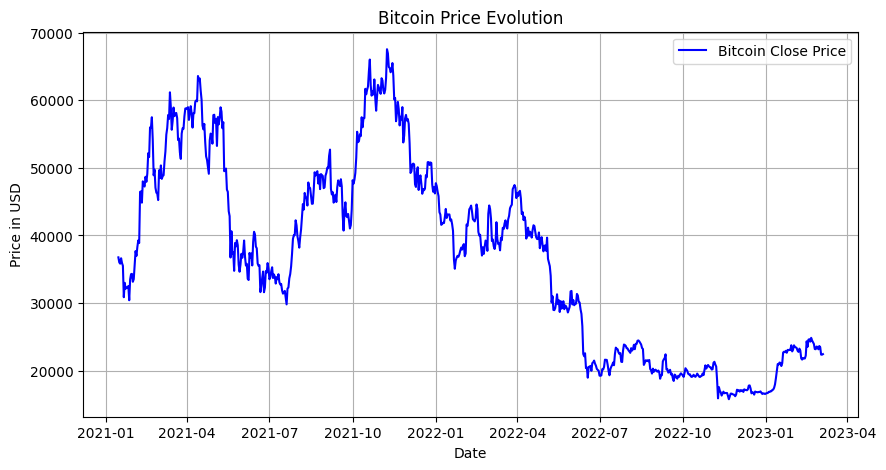

In [15]:
import matplotlib.pyplot as plt

# Ensure the index is a datetime type
full_data.index = pd.to_datetime(full_data.index)


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(full_data['close'], label='Bitcoin Close Price', color='blue')
plt.title('Bitcoin Price Evolution')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,3].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,3].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,3].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 3].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,3].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,3] - 1)

    return data


In [17]:
tech_df = get_tech_ind(full_data)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.head()


,low,high,open,close,volume,Date,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,36156.45,38769.00,37688.42,36975.00,31699.362923,2021-02-04,35059.244286,34109.8255,-1795.898225,2071.578085,38252.981669,29966.669331,36894.680718,10.517970
1,36605.87,38349.00,36976.59,38311.49,17842.701732,2021-02-05,35637.727143,34225.0530,-1776.390626,2239.909221,38704.871442,29745.234558,37839.220239,10.553479
2,38250.00,41000.00,38327.09,39265.43,27102.806029,2021-02-06,36344.841429,34397.3245,-2065.171833,2487.808886,39372.942273,29421.706727,38790.026746,10.578074
3,37371.35,39737.83,39266.10,38871.42,20297.872561,2021-02-07,37163.938571,34509.6840,-2129.206970,2639.782660,39789.249320,29230.118680,38844.288915,10.567989
4,38057.01,46750.00,38871.43,46448.10,47934.010388,2021-02-08,39008.925714,35036.2250,-2587.273789,3751.491906,42539.208813,27533.241187,43913.496305,10.746069


In [18]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    #ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()


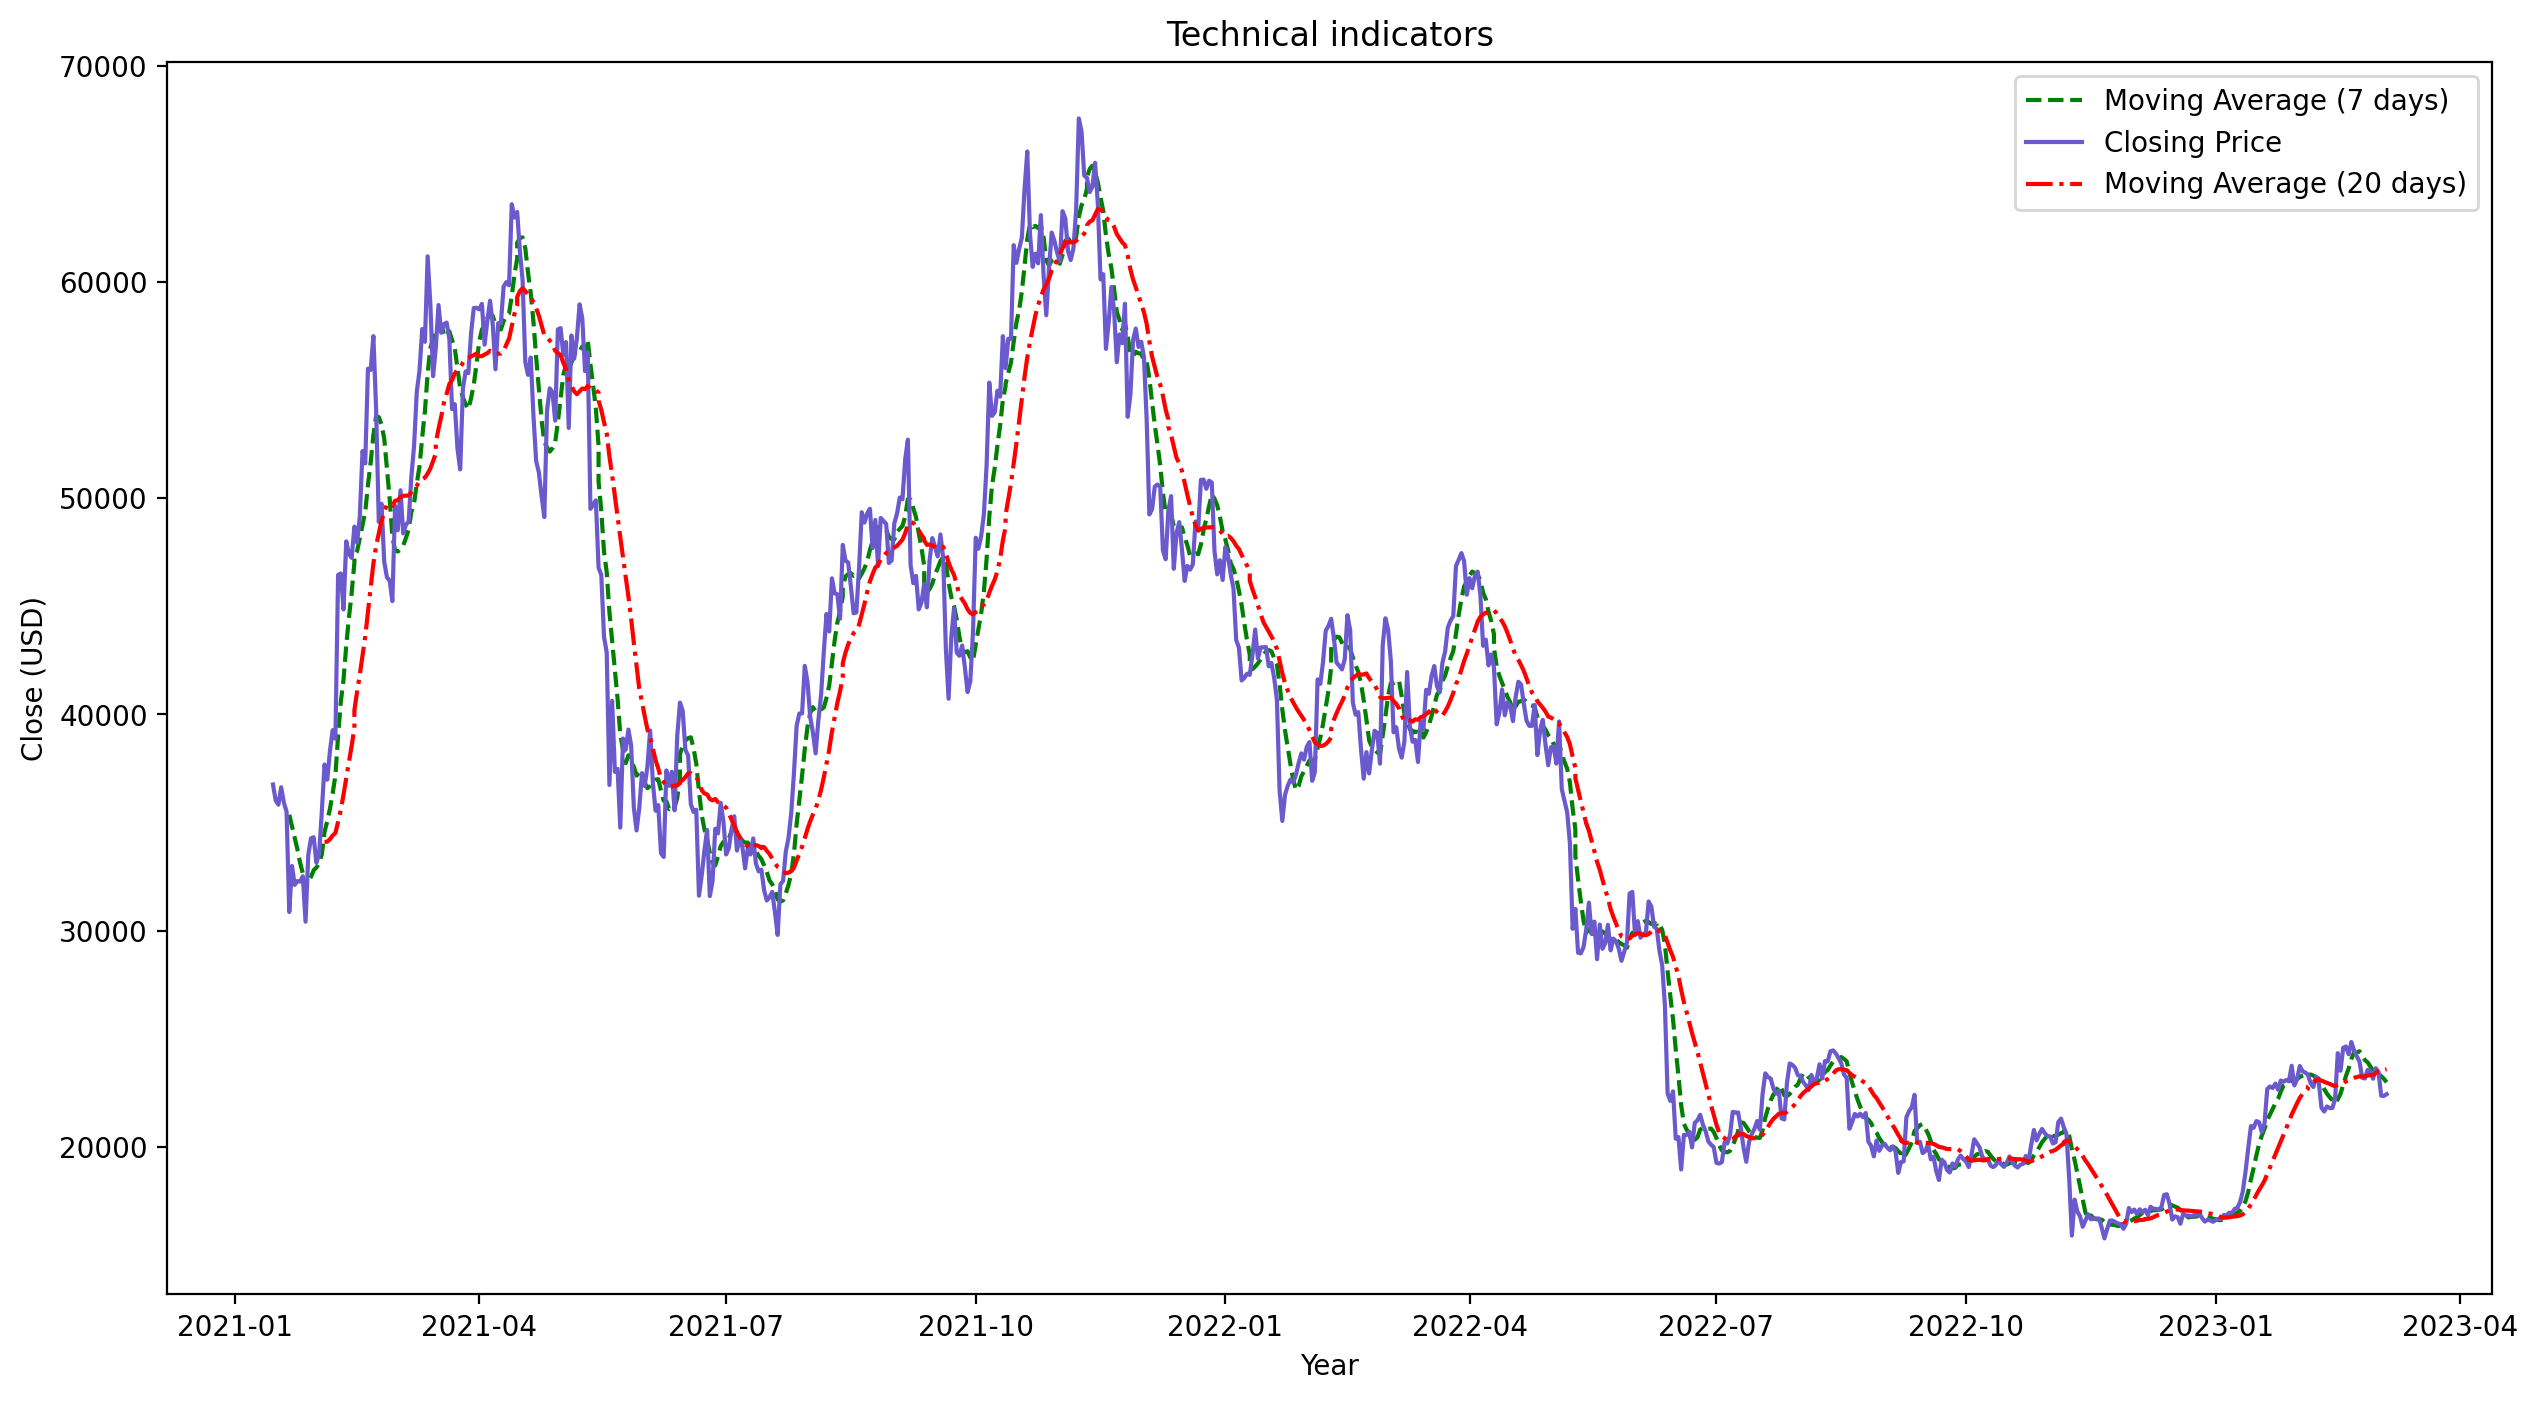

In [19]:
tech_ind(tech_df)


In [20]:
# deal with missing data by fill forward (if any)
dataset.iloc[:, :] = pd.concat([dataset.iloc[:, :].ffill()])


In [21]:
#dataset = pd.merge(dataset, positive_df, how='left', on='Date')
#dataset = pd.merge(dataset, negative_df, how='left', on='Date')
#dataset = pd.merge(dataset, neutral_df, how='left', on='Date')
dataset = pd.merge(dataset, joy_df, how='left', on='Date')
dataset = pd.merge(dataset, sadness_df, how='left', on='Date')
dataset = pd.merge(dataset, surprise_df, how='left', on='Date')
dataset

,low,high,open,close,volume,Date,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,weighted_joy_prob,weighted_sadness_prob,weighted_surprise_prob
0,36156.45,38769.00,37688.42,36975.00,31699.362923,2021-02-04,35059.244286,34109.8255,-1795.898225,2071.578085,38252.981669,29966.669331,36894.680718,10.517970,NaN,NaN,NaN
1,36605.87,38349.00,36976.59,38311.49,17842.701732,2021-02-05,35637.727143,34225.0530,-1776.390626,2239.909221,38704.871442,29745.234558,37839.220239,10.553479,0.421450,0.013635,0.026184
2,38250.00,41000.00,38327.09,39265.43,27102.806029,2021-02-06,36344.841429,34397.3245,-2065.171833,2487.808886,39372.942273,29421.706727,38790.026746,10.578074,0.410847,0.016955,0.021055
3,37371.35,39737.83,39266.10,38871.42,20297.872561,2021-02-07,37163.938571,34509.6840,-2129.206970,2639.782660,39789.249320,29230.118680,38844.288915,10.567989,0.312317,0.043263,0.020297
4,38057.01,46750.00,38871.43,46448.10,47934.010388,2021-02-08,39008.925714,35036.2250,-2587.273789,3751.491906,42539.208813,27533.241187,43913.496305,10.746069,0.531602,0.010750,0.028127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,23025.17,23999.99,23144.37,23631.52,12151.845398,2023-03-01,23444.728571,23410.7590,-725.859668,1052.311209,25515.381419,21306.136581,23506.600414,10.070294,0.375149,0.036470,0.020444
781,23196.09,23798.62,23632.12,23468.24,9239.936445,2023-03-02,23376.860000,23502.7225,-680.942562,965.161701,25433.045902,21572.399098,23481.026805,10.063361,0.369705,0.039441,0.019730
782,21988.02,23477.28,23468.79,22358.18,21715.093557,2023-03-03,23258.474286,23527.4450,-674.545825,926.528954,25380.502908,21674.387092,22732.462268,10.014903,0.328176,0.054426,0.021665
783,22150.71,22409.82,22358.18,22350.95,2266.214979,2023-03-04,23142.937143,23555.5025,-510.911222,878.385122,25312.272744,21798.732256,22478.120756,10.014579,0.352609,0.047399,0.016926


In [22]:
# sorting the DataFrame by the date, and then removing the original date column. 
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')
dataset

,low,high,open,close,volume,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,weighted_joy_prob,weighted_sadness_prob,weighted_surprise_prob
2021-02-04,36156.45,38769.00,37688.42,36975.00,31699.362923,35059.244286,34109.8255,-1795.898225,2071.578085,38252.981669,29966.669331,36894.680718,10.517970,NaN,NaN,NaN
2021-02-05,36605.87,38349.00,36976.59,38311.49,17842.701732,35637.727143,34225.0530,-1776.390626,2239.909221,38704.871442,29745.234558,37839.220239,10.553479,0.421450,0.013635,0.026184
2021-02-06,38250.00,41000.00,38327.09,39265.43,27102.806029,36344.841429,34397.3245,-2065.171833,2487.808886,39372.942273,29421.706727,38790.026746,10.578074,0.410847,0.016955,0.021055
2021-02-07,37371.35,39737.83,39266.10,38871.42,20297.872561,37163.938571,34509.6840,-2129.206970,2639.782660,39789.249320,29230.118680,38844.288915,10.567989,0.312317,0.043263,0.020297
2021-02-08,38057.01,46750.00,38871.43,46448.10,47934.010388,39008.925714,35036.2250,-2587.273789,3751.491906,42539.208813,27533.241187,43913.496305,10.746069,0.531602,0.010750,0.028127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,23025.17,23999.99,23144.37,23631.52,12151.845398,23444.728571,23410.7590,-725.859668,1052.311209,25515.381419,21306.136581,23506.600414,10.070294,0.375149,0.036470,0.020444
2023-03-02,23196.09,23798.62,23632.12,23468.24,9239.936445,23376.860000,23502.7225,-680.942562,965.161701,25433.045902,21572.399098,23481.026805,10.063361,0.369705,0.039441,0.019730
2023-03-03,21988.02,23477.28,23468.79,22358.18,21715.093557,23258.474286,23527.4450,-674.545825,926.528954,25380.502908,21674.387092,22732.462268,10.014903,0.328176,0.054426,0.021665
2023-03-04,22150.71,22409.82,22358.18,22350.95,2266.214979,23142.937143,23555.5025,-510.911222,878.385122,25312.272744,21798.732256,22478.120756,10.014579,0.352609,0.047399,0.016926


In [23]:
cols = list(dataset.columns)

col_to_move = 'close'
cols.insert(0, cols.pop(cols.index(col_to_move)))

# 重新索引 DataFrame
dataset = dataset[cols]
dataset

,close,low,high,open,volume,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,weighted_joy_prob,weighted_sadness_prob,weighted_surprise_prob
2021-02-04,36975.00,36156.45,38769.00,37688.42,31699.362923,35059.244286,34109.8255,-1795.898225,2071.578085,38252.981669,29966.669331,36894.680718,10.517970,NaN,NaN,NaN
2021-02-05,38311.49,36605.87,38349.00,36976.59,17842.701732,35637.727143,34225.0530,-1776.390626,2239.909221,38704.871442,29745.234558,37839.220239,10.553479,0.421450,0.013635,0.026184
2021-02-06,39265.43,38250.00,41000.00,38327.09,27102.806029,36344.841429,34397.3245,-2065.171833,2487.808886,39372.942273,29421.706727,38790.026746,10.578074,0.410847,0.016955,0.021055
2021-02-07,38871.42,37371.35,39737.83,39266.10,20297.872561,37163.938571,34509.6840,-2129.206970,2639.782660,39789.249320,29230.118680,38844.288915,10.567989,0.312317,0.043263,0.020297
2021-02-08,46448.10,38057.01,46750.00,38871.43,47934.010388,39008.925714,35036.2250,-2587.273789,3751.491906,42539.208813,27533.241187,43913.496305,10.746069,0.531602,0.010750,0.028127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,23631.52,23025.17,23999.99,23144.37,12151.845398,23444.728571,23410.7590,-725.859668,1052.311209,25515.381419,21306.136581,23506.600414,10.070294,0.375149,0.036470,0.020444
2023-03-02,23468.24,23196.09,23798.62,23632.12,9239.936445,23376.860000,23502.7225,-680.942562,965.161701,25433.045902,21572.399098,23481.026805,10.063361,0.369705,0.039441,0.019730
2023-03-03,22358.18,21988.02,23477.28,23468.79,21715.093557,23258.474286,23527.4450,-674.545825,926.528954,25380.502908,21674.387092,22732.462268,10.014903,0.328176,0.054426,0.021665
2023-03-04,22350.95,22150.71,22409.82,22358.18,2266.214979,23142.937143,23555.5025,-510.911222,878.385122,25312.272744,21798.732256,22478.120756,10.014579,0.352609,0.047399,0.016926


In [24]:
# deal with missing data by fill forward (if any)
dataset.iloc[:, :] = pd.concat([dataset.iloc[:, :].ffill()])
dataset = dataset[1:]

# Try run LSTM

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset['close'][:20].values.reshape(-1, 1))

preddays = 5

x_train, y_train = [], []
for x in range(preddays, len(scaled_data)):
    x_train.append(scaled_data[x-preddays:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [27]:
x_train.shape, y_train.shape 

((15, 5, 1), (15,))

In [30]:
np.isnan(x_train).any(), np.isnan(y_train).any()

(False, False)

In [31]:
from keras.layers import Input

model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))  # Define the input shape explicitly
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(units=50))
#model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10


# LSTM

In [30]:
from sklearn.preprocessing import MinMaxScaler
# train test split
train_size = int(0.9*len(dataset))
training_set = dataset.iloc[:train_size].values
test_set = dataset.iloc[train_size:].values
# normalize the dataset
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
chunk_length = 10  # size of the chunk for LSTM
for i in range(chunk_length, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - chunk_length:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [31]:
X_train.shape, y_train.shape

((695, 10, 16), (695,))

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
#regressor.add(LSTM(units=100, return_sequences=True, input_shape=(5,5)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))


regressor.compile(optimizer='adam',loss='mean_squared_error')


/Users/webber900114/miniconda3/envs/stenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
history_all = regressor.fit(X_train[:,:,:], y_train[:], epochs=100,batch_size=32,validation_split=0.2)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1063 - val_loss: 0.0093
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0210 - val_loss: 8.9459e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0166 - val_loss: 0.0013
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0122 - val_loss: 6.2407e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0139 - val_loss: 0.0013
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0129 - val_loss: 9.6627e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0131 - val_loss: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0124 - val_loss: 0.0011
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0127 - val_loss: 7.9575e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0100 - val_loss: 8.0325e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0101 - val_loss: 0.0011
Epoch 12/100
18/18 ━━━━━━━━━━━━━

Text(0, 0.5, 'loss')

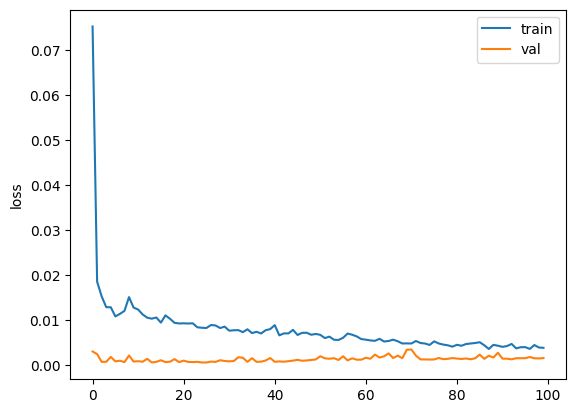

In [369]:
plt.plot(history_all.history['loss'], label='train')
plt.plot(history_all.history['val_loss'], label='val')
plt.legend()
plt.ylabel('loss')

In [370]:
# prediction
# pre-processing the data 
inputs = dataset[len(dataset)-len(test_set) - chunk_length:].values
#inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# making the test data
X_test = []
for i in range(chunk_length,len(inputs)):
  X_test.append(inputs[i-chunk_length:i])
X_test = np.array(X_test)
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(np.concatenate((inputs[chunk_length:,1:], predicted_stock_price), axis=1))[:,0]


3/3 [==============================] - 1s 4ms/step


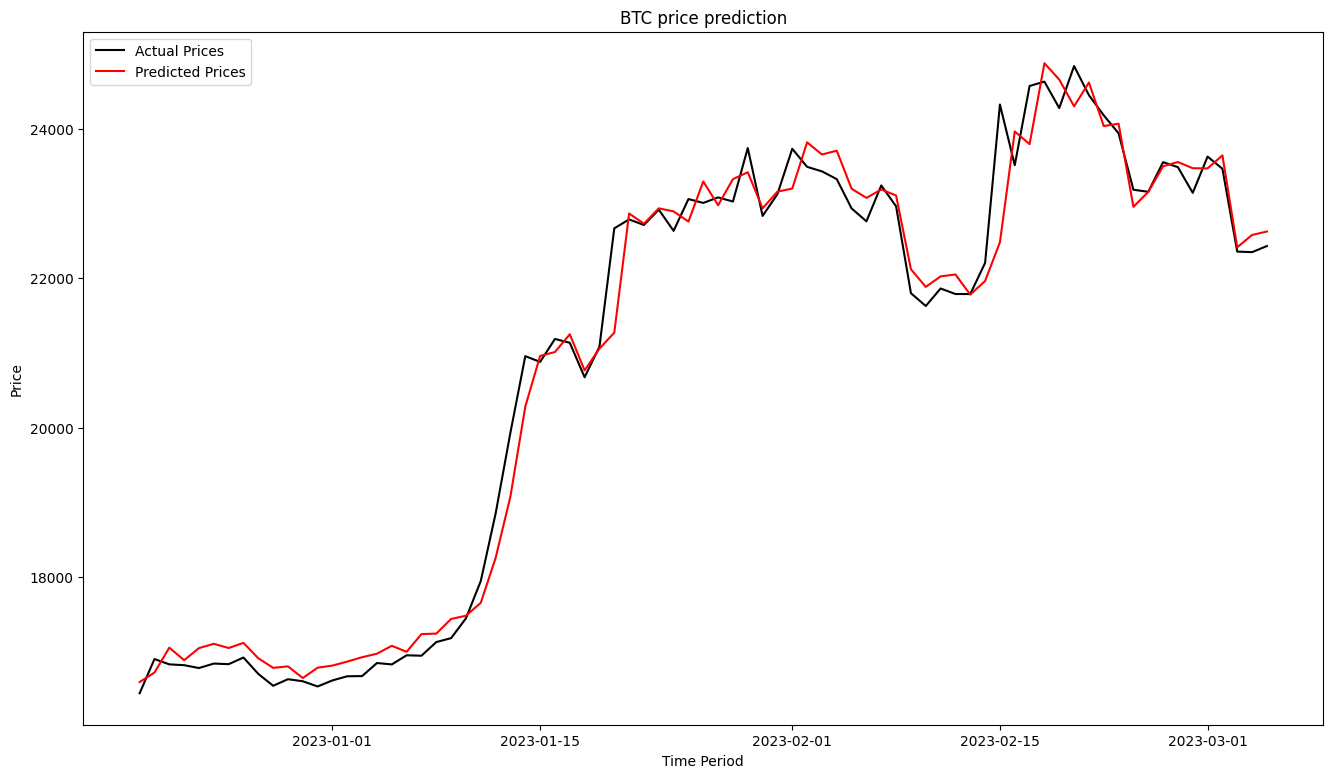

RME:  380.656558193044


In [371]:
plt.figure(figsize=(16,9))
plt.plot(dataset.iloc[train_size:].index,dataset.iloc[train_size:,0], color='black', label='Actual Prices')
plt.plot(dataset.iloc[train_size:].index,predicted_stock_price, color='red', label='Predicted Prices')
plt.title(f'BTC price prediction')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()
RME = sqrt(mean_squared_error(dataset.iloc[train_size:,0], predicted_stock_price))
print("RME: ", RME)
#plt.savefig("btc_price_prediction", dpi=1000)


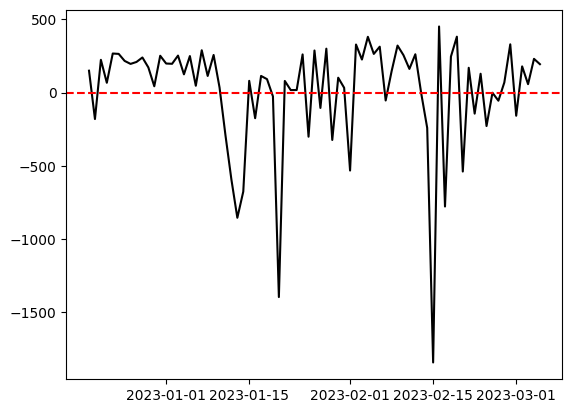

In [372]:
plt.plot(dataset.iloc[train_size:].index,predicted_stock_price - dataset.iloc[train_size:,0], color='black', label='Actual Prices')
plt.axhline(y=0, color='r', linestyle='--')


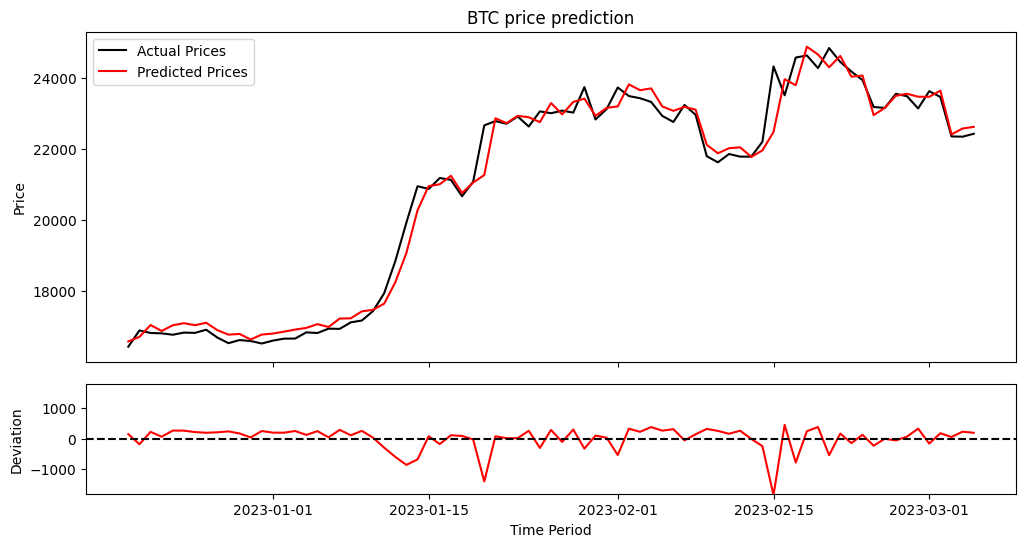

In [345]:
# share x axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,6))

ax1.plot(dataset.iloc[train_size:].index,dataset.iloc[train_size:,0], color='black', label='Actual Prices')
ax1.plot(dataset.iloc[train_size:].index,predicted_stock_price, color='red', label='Predicted Prices')
ax1.set_title(f'BTC price prediction')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

ax2.plot(dataset.iloc[train_size:].index,predicted_stock_price - dataset.iloc[train_size:,0], color='r') 
ax2.axhline(y=0, color='black', linestyle='--')

ax2.set_ylabel('Deviation')
ax2.set_xlabel('Time Period')
ax2.set_ylim(-1800,1800)
plt.subplots_adjust(hspace=0.1)

plt.show()


## hyper-tune parameter in LSTM

In [47]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

def create_model(units1=100, units2=80, units3=50, units4=30):
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=units1, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    regressor.add(Dropout(0.3))

    regressor.add(LSTM(units=units2, return_sequences=True))
    regressor.add(Dropout(0.1))

    regressor.add(LSTM(units=units3, return_sequences=True))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units=units4))
    regressor.add(Dropout(0.3))

    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam',loss='mean_squared_error')
    return regressor


units_grid = {
    'units1': [100, 200],
    'units2': [50,80],
    'units3': [30,50],
    'units4': [30,20]
}

from sklearn.model_selection import ParameterGrid

# 伪代码和简化的逻辑，需要根据实际情况调整
best_score = float('inf')
best_params = {}

for params in ParameterGrid(units_grid):
    model = create_model(**params)
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)
    
    # 评估模型并保存表现最好的参数
    score = np.min(history.history['val_loss'])  # 假设你有一个验证集来评估模型
    if score < best_score:
        best_score = score
        best_params = params

print('Best score:', best_score)
print('Best params:', best_params)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1677 - val_loss: 0.0138
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0292 - val_loss: 0.0035
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - val_loss: 6.4423e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - val_loss: 0.0026
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - val_loss: 0.0012
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - val_loss: 7.9761e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - val_loss: 0.0015
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127 - val_loss: 0.0012
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113 - val_loss: 0.0011
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0102 - val_loss: 0.0015
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - val_loss: 8.6772e-04
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

In [64]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
#regressor.add(LSTM(units=100, return_sequences=True, input_shape=(5,5)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))


regressor.compile(optimizer='adam',loss='mean_squared_error')


/Users/webber900114/miniconda3/envs/stenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
history_all = regressor.fit(X_train[:,:,:], y_train[:], epochs=100,batch_size=32,validation_split=0.2)

Epoch 1/100


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1457 - val_loss: 0.0094
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0251 - val_loss: 9.5557e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - val_loss: 8.5394e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0181 - val_loss: 8.9309e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - val_loss: 0.0011
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144 - val_loss: 7.8225e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - val_loss: 9.4498e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - val_loss: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - val_loss: 0.0010
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0125 - val_loss: 7.1096e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0115 - val_loss: 0.0015
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0

Text(0, 0.5, 'loss')

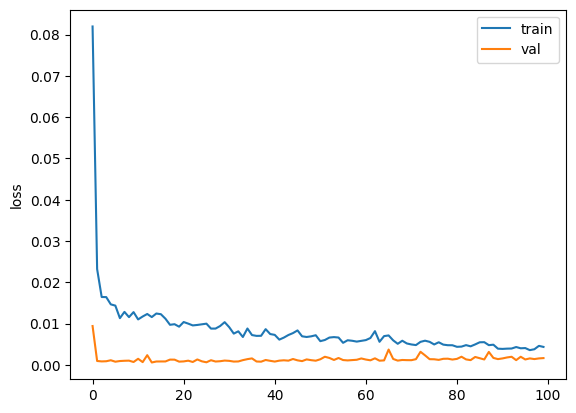

In [66]:
plt.plot(history_all.history['loss'], label='train')
plt.plot(history_all.history['val_loss'], label='val')
plt.legend()
plt.ylabel('loss')

In [67]:
# prediction
# pre-processing the data 
inputs = dataset[len(dataset)-len(test_set) - chunk_length:].values
#inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# making the test data
X_test = []
for i in range(chunk_length,len(inputs)):
  X_test.append(inputs[i-chunk_length:i])
X_test = np.array(X_test)
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(np.concatenate((inputs[chunk_length:,1:], predicted_stock_price), axis=1))[:,0]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


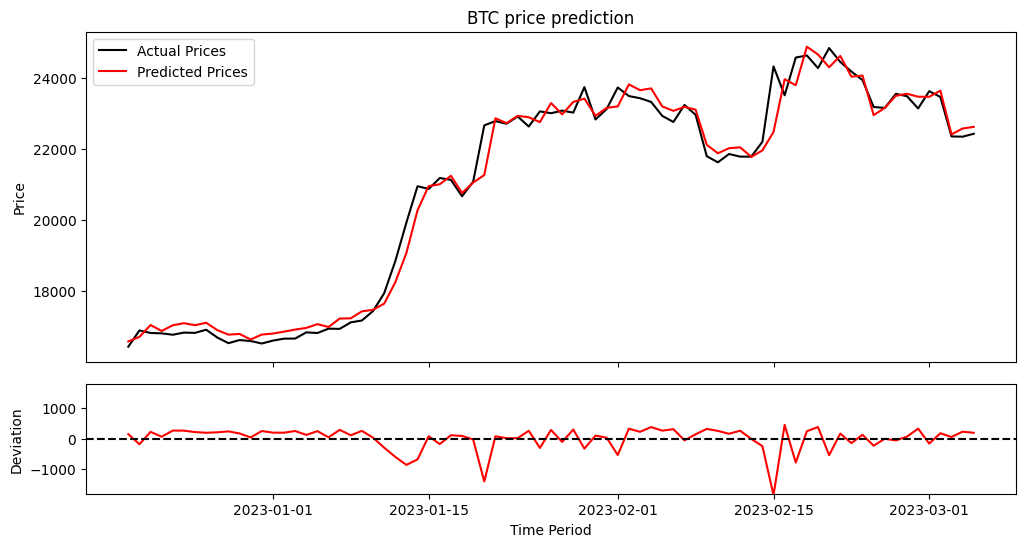

RME:  380.656558193044


In [68]:
# share x axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,6))

ax1.plot(dataset.iloc[train_size:].index,dataset.iloc[train_size:,0], color='black', label='Actual Prices')
ax1.plot(dataset.iloc[train_size:].index,predicted_stock_price, color='red', label='Predicted Prices')
ax1.set_title(f'BTC price prediction')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

ax2.plot(dataset.iloc[train_size:].index,predicted_stock_price - dataset.iloc[train_size:,0], color='r') 
ax2.axhline(y=0, color='black', linestyle='--')

ax2.set_ylabel('Deviation')
ax2.set_xlabel('Time Period')
ax2.set_ylim(-1800,1800)
plt.subplots_adjust(hspace=0.1)

plt.show()
print("RME: ", sqrt(mean_squared_error(dataset.iloc[train_size:,0], predicted_stock_price)))

## only use NLP data

In [239]:
from sklearn.preprocessing import MinMaxScaler
# train test split
index = ['close','weighted_positive_prob','weighted_negative_prob','weighted_neutral_prob']
dataset_new = dataset.copy()[index]

train_size = int(0.9*len(dataset))
training_set = dataset_new.iloc[:train_size].values
test_set = dataset_new.iloc[train_size:].values
# normalize the dataset
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
chunk_length = 10  # size of the chunk for LSTM
for i in range(chunk_length, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - chunk_length:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [240]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
#regressor.add(LSTM(units=100, return_sequences=True, input_shape=(5,5)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))


regressor.compile(optimizer='adam',loss='mean_squared_error')


In [241]:
X_train.shape, y_train.shape

((695, 10, 4), (695,))

In [242]:
history = regressor.fit(X_train[:,:,:], y_train[:], epochs=100,batch_size=32,validation_split=0.2)

Epoch 1/100


18/18 [==============================] - 4s 42ms/step - loss: 0.0986 - val_loss: 0.0419
Epoch 2/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0279 - val_loss: 0.0156
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0148 - val_loss: 5.9229e-04
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0141 - val_loss: 0.0042
Epoch 5/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0123 - val_loss: 0.0012
Epoch 6/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0130 - val_loss: 6.2527e-04
Epoch 7/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0134 - val_loss: 0.0027
Epoch 8/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0128 - val_loss: 6.4934e-04
Epoch 9/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0113 - val_loss: 9.5090e-04
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0126 - val_loss: 0.

Text(0, 0.5, 'loss')

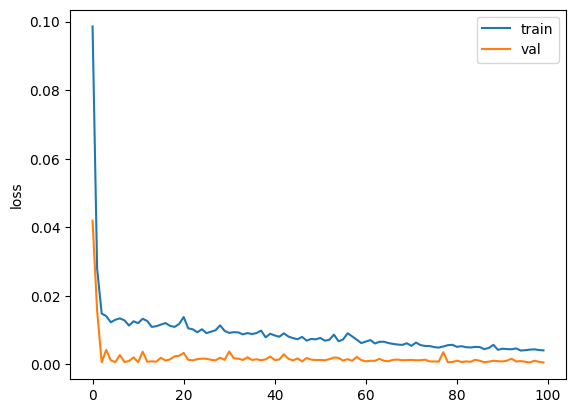

In [243]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.ylabel('loss')

3/3 [==============================] - 0s 4ms/step


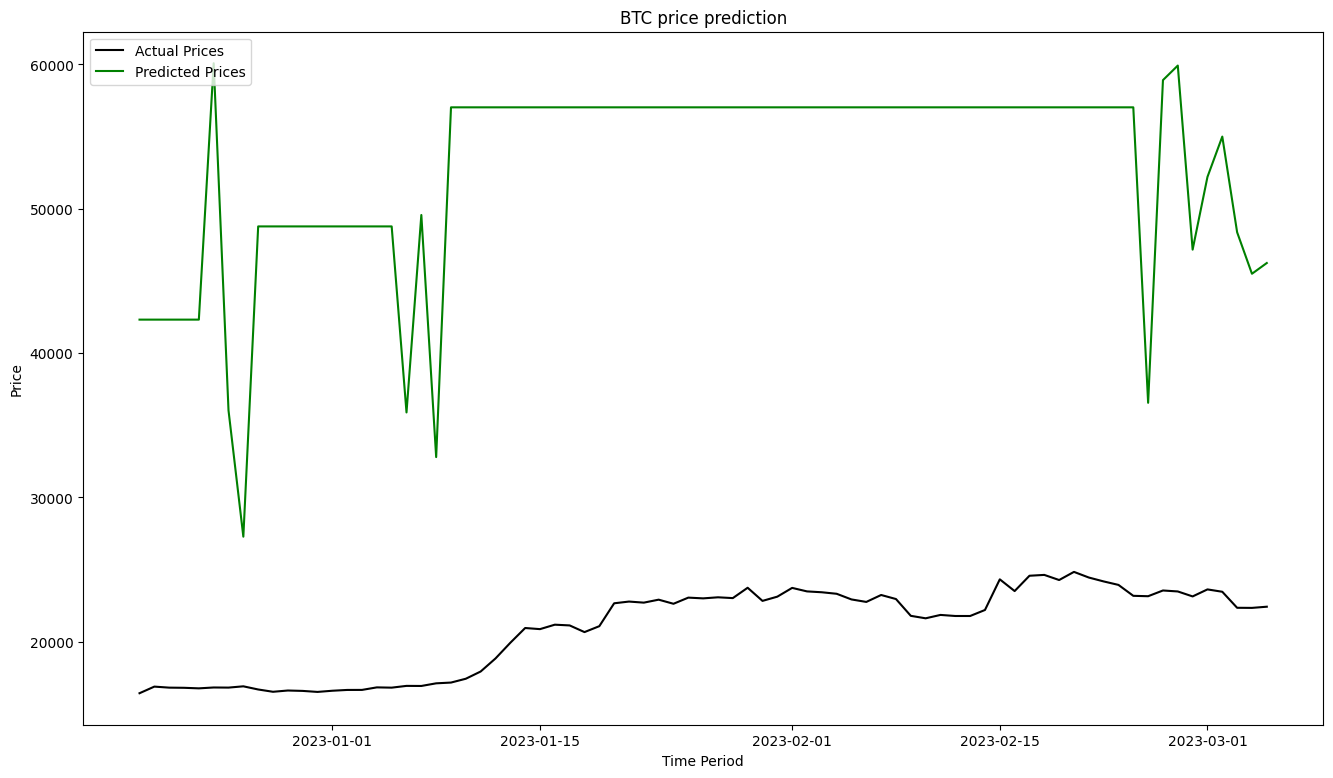

RME:  32462.083205053314


In [246]:
# prediction
# pre-processing the data 
inputs = dataset_new[len(dataset_new)-len(test_set) - chunk_length:].values
#inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# making the test data
X_test = []
for i in range(chunk_length,len(inputs)):
  X_test.append(inputs[i-chunk_length:i])
X_test = np.array(X_test)
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(np.concatenate((inputs[chunk_length:,1:], predicted_stock_price), axis=1))[:,0]

plt.figure(figsize=(16,9))
plt.plot(dataset.iloc[train_size:].index,dataset.iloc[train_size:,0], color='black', label='Actual Prices')
plt.plot(dataset.iloc[train_size:].index,predicted_stock_price, color='red', label='Predicted Prices')
plt.title(f'BTC price prediction')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()
#plt.savefig("btc_price_prediction", dpi=1000)
print("RME: ", sqrt(mean_squared_error(dataset.iloc[train_size:,0], predicted_stock_price)))

## no NLP data

In [346]:
dataset.columns

Index(['close', 'low', 'high', 'open', 'volume', 'MA7', 'MA20', 'MACD', '20SD',
       'upper_band', 'lower_band', 'EMA', 'logmomentum',
       'weighted_positive_prob', 'weighted_negative_prob',
       'weighted_neutral_prob'],
      dtype='object')

In [347]:
from sklearn.preprocessing import MinMaxScaler
# train test split
#index = ['close', 'high', 'open', 'volume', 'MA7', 'MA20', 'MACD', '20SD', 'upper_band', 'lower_band', 'EMA', 'logmomentum']
dataset_new = dataset.copy()[index]

train_size = int(0.9*len(dataset))
training_set = dataset_new.iloc[:train_size].values
test_set = dataset_new.iloc[train_size:].values
# normalize the dataset
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
chunk_length = 10  # size of the chunk for LSTM
for i in range(chunk_length, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - chunk_length:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(695, 10, 12) (695,)


Epoch 1/100
18/18 [==============================] - 4s 47ms/step - loss: 0.0874 - val_loss: 0.0021
Epoch 2/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0261 - val_loss: 0.0013
Epoch 3/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0175 - val_loss: 0.0012
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0159 - val_loss: 0.0010
Epoch 5/100
18/18 [==============================] - 0s 15ms/step - loss: 0.0147 - val_loss: 0.0014
Epoch 6/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0126 - val_loss: 6.1636e-04
Epoch 7/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0114 - val_loss: 8.0135e-04
Epoch 8/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0119 - val_loss: 0.0021
Epoch 9/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0123 - val_loss: 5.1262e-04
Epoch 10/100
18/18 [==============================] - 0s 14ms/step - loss: 0.0118 - val_

Text(0, 0.5, 'loss')

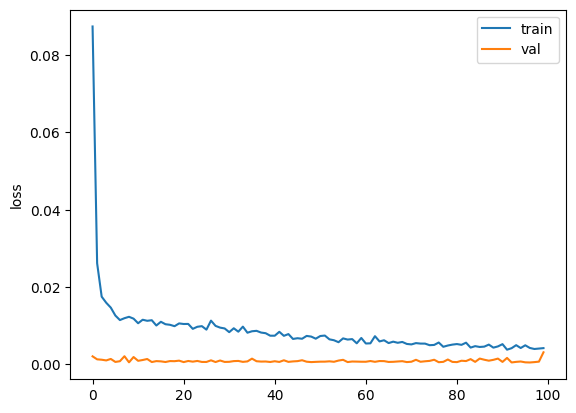

In [348]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
#regressor.add(LSTM(units=100, return_sequences=True, input_shape=(5,5)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))


regressor.compile(optimizer='adam',loss='mean_squared_error')

history_no_nlp = regressor.fit(X_train[:,:,:], y_train[:], epochs=100,batch_size=32,validation_split=0.2)

plt.plot(history_no_nlp.history['loss'], label='train')
plt.plot(history_no_nlp.history['val_loss'], label='val')
plt.legend()
plt.ylabel('loss')

3/3 [==============================] - 1s 4ms/step


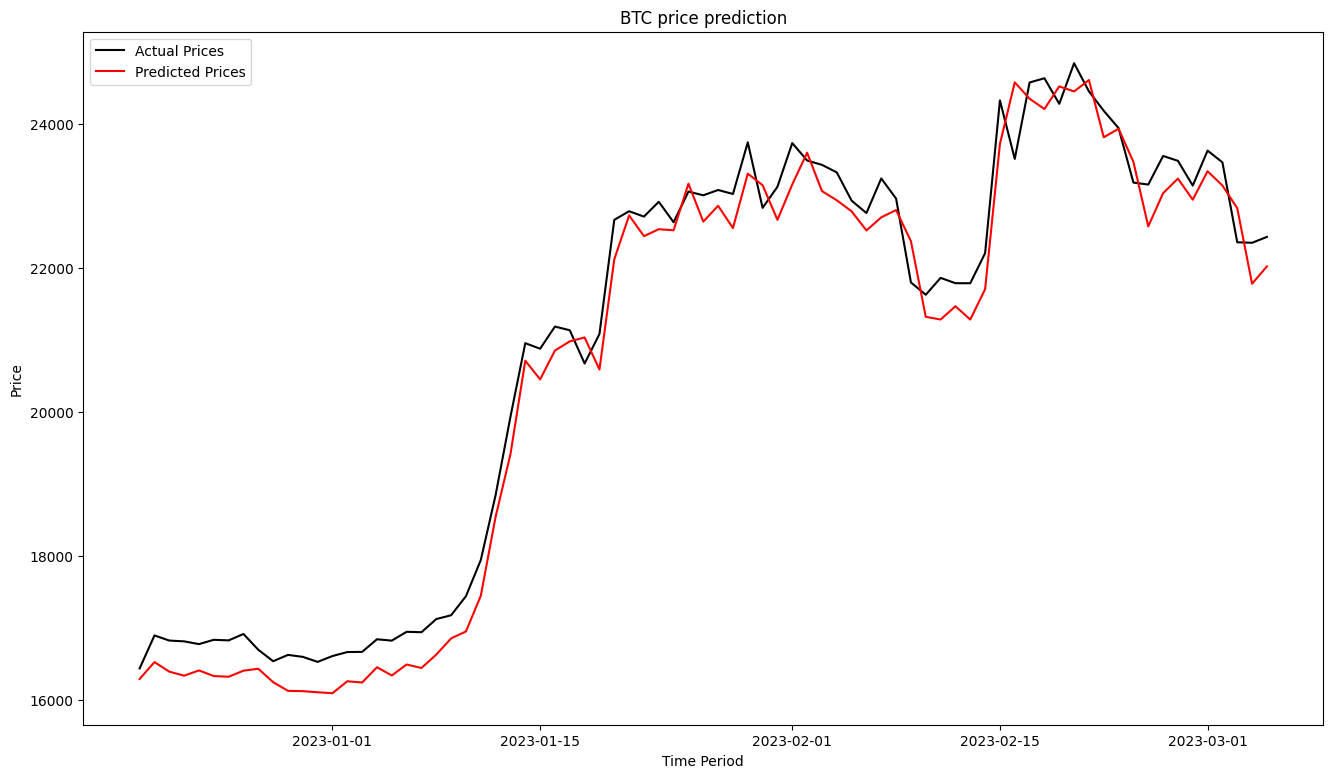

RME:  416.25388577727176


In [349]:
# prediction
# pre-processing the data 
inputs = dataset_new[len(dataset_new)-len(test_set) - chunk_length:].values
#inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# making the test data
X_test = []
for i in range(chunk_length,len(inputs)):
  X_test.append(inputs[i-chunk_length:i])
X_test = np.array(X_test)
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(np.concatenate((inputs[chunk_length:,1:], predicted_stock_price), axis=1))[:,0]

plt.figure(figsize=(16,9))
plt.plot(dataset_new.iloc[train_size:].index,dataset_new.iloc[train_size:,0], color='black', label='Actual Prices')
plt.plot(dataset_new.iloc[train_size:].index,predicted_stock_price, color='red', label='Predicted Prices')
plt.title(f'BTC price prediction')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()
#plt.savefig("btc_price_prediction", dpi=1000)
RME = sqrt(mean_squared_error(dataset_new.iloc[train_size:,0], predicted_stock_price))
print("RME: ", RME)


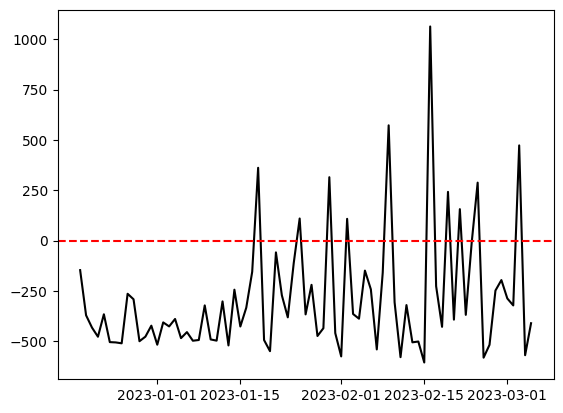

In [350]:
plt.plot(dataset.iloc[train_size:].index,predicted_stock_price - dataset.iloc[train_size:,0], color='black', label='Actual Prices')
plt.axhline(y=0, color='r', linestyle='--')


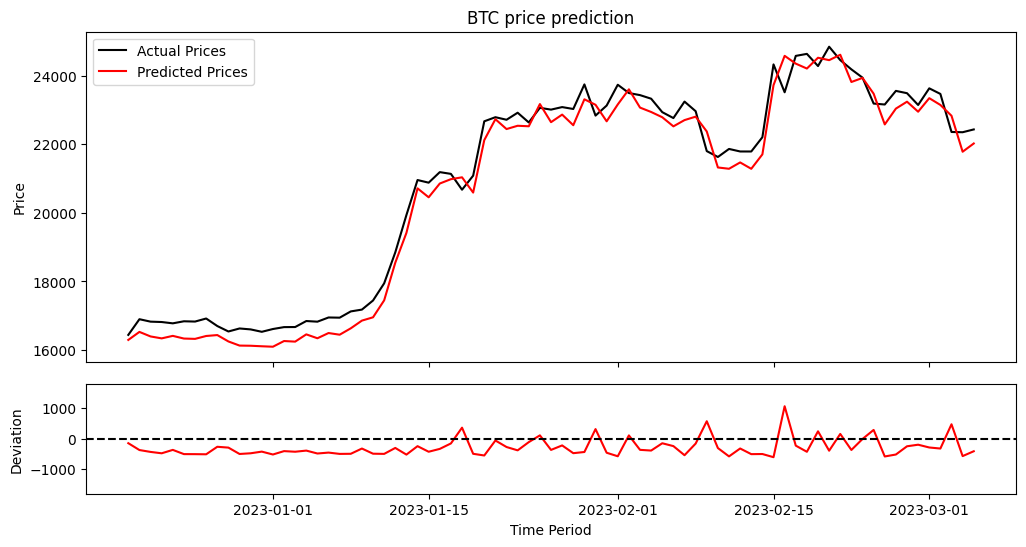

In [351]:
# share x axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,6))

ax1.plot(dataset.iloc[train_size:].index,dataset.iloc[train_size:,0], color='black', label='Actual Prices')
ax1.plot(dataset.iloc[train_size:].index,predicted_stock_price, color='red', label='Predicted Prices')
ax1.set_title(f'BTC price prediction')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

ax2.plot(dataset.iloc[train_size:].index,predicted_stock_price - dataset.iloc[train_size:,0], color='r') 
ax2.axhline(y=0, color='black', linestyle='--')

ax2.set_ylabel('Deviation')
ax2.set_xlabel('Time Period')
ax2.set_ylim(-1800,1800)
plt.subplots_adjust(hspace=0.1)

plt.show()


## emotional data

In [424]:
from sklearn.preprocessing import MinMaxScaler
# train test split
dataset_new = dataset.copy()[index]

train_size = int(0.9*len(dataset))
training_set = dataset_new.iloc[:train_size].values
test_set = dataset_new.iloc[train_size:].values
# normalize the dataset
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
chunk_length = 20  # size of the chunk for LSTM
for i in range(chunk_length, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - chunk_length:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(685, 20, 2) (685,)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
#regressor.add(LSTM(units=100, return_sequences=True, input_shape=(5,5)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))


regressor.compile(optimizer='adam',loss='mean_squared_error')

history_no_nlp = regressor.fit(X_train[:,:,:], y_train[:], epochs=100,batch_size=32,validation_split=0.2)

plt.plot(history_no_nlp.history['loss'], label='train')
plt.plot(history_no_nlp.history['val_loss'], label='val')
plt.legend()
plt.ylabel('loss')

In [ ]:
# prediction
# pre-processing the data 
inputs = dataset_new[len(dataset_new)-len(test_set) - chunk_length:].values
#inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# making the test data
X_test = []
for i in range(chunk_length,len(inputs)):
  X_test.append(inputs[i-chunk_length:i])
X_test = np.array(X_test)
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(np.concatenate((inputs[chunk_length:,1:], predicted_stock_price), axis=1))[:,0]

plt.figure(figsize=(16,9))
plt.plot(dataset_new.iloc[train_size:].index,dataset_new.iloc[train_size:,0], color='black', label='Actual Prices')
plt.plot(dataset_new.iloc[train_size:].index,predicted_stock_price, color='red', label='Predicted Prices')
plt.title(f'BTC price prediction')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()
#plt.savefig("btc_price_prediction", dpi=1000)
RME = sqrt(mean_squared_error(dataset_new.iloc[train_size:,0], predicted_stock_price))
print("RME: ", RME)


In [ ]:
# share x axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,6))

ax1.plot(dataset.iloc[train_size:].index,dataset.iloc[train_size:,0], color='black', label='Actual Prices')
ax1.plot(dataset.iloc[train_size:].index,predicted_stock_price, color='red', label='Predicted Prices')
ax1.set_title(f'BTC price prediction')
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

ax2.plot(dataset.iloc[train_size:].index,predicted_stock_price - dataset.iloc[train_size:,0], color='r') 
ax2.axhline(y=0, color='black', linestyle='--')

ax2.set_ylabel('Deviation')
ax2.set_xlabel('Time Period')
ax2.set_ylim(-1800,1800)
plt.subplots_adjust(hspace=0.1)

plt.show()
print("RME: ", sqrt(mean_squared_error(dataset_new.iloc[train_size:,0], predicted_stock_price)))